In [1]:
!cat ~/.keras/keras.json

{
    "epsilon": 1e-07, 
    "floatx": "float32", 
    "image_data_format": "channels_last", 
    "backend": "tensorflow"
}

Preprocessing

In [2]:
import numpy as np
import cv2
import os

In [3]:
class SimplePreprocessor:
  def __init__(self, width, height, inter=cv2.INTER_AREA):
    self.width = width
    self.height = height
    self.inter = inter

  # resize the image to a fixed size, ignoring the aspect ratio
  def preprocess(self, image):
    return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []

        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label assuming
            # that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]

            # check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # loop over the preprocessors and apply each to
                # the image
                for p in self.preprocessors:
                    image = p.preprocess(image)

            # treat our processed image as a "feature vector"
            # by updating the data list followed by the labels
            data.append(image)
            labels.append(label)

            # show an update every `verbose` images
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1,
                    len(imagePaths)))

        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))

Image to Array Preprocessor (required for keras)

In [4]:
from keras.preprocessing.image import img_to_array

In [5]:
class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return img_to_array(image, data_format=self.dataFormat)

ShallowNet

INPUT => CONV => RELU => FC

In [6]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

In [7]:
class ShallowNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# define the first (and only) CONV => RELU layer
		model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Flatten()) # required before FC
		model.add(Dense(classes)) # integer
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Shallownet (Animals)

In [8]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def train_animals(dataset):
    # grab the list of images that we'll be describing
    print("[INFO] loading images...")
    imagePaths = list(paths.list_images(dataset))

    # initialize the image preprocessors
    sp = SimplePreprocessor(32, 32)
    iap = ImageToArrayPreprocessor()

    # load the dataset from disk then scale the raw pixel intensities
    # to the range [0, 1]
    sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
    (data, labels) = sdl.load(imagePaths, verbose=500)
    data = data.astype("float") / 255.0

    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

    # convert the labels from integers to vectors
    trainY = LabelBinarizer().fit_transform(trainY)
    testY = LabelBinarizer().fit_transform(testY)

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.005)
    model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # train the network
    print("[INFO] training network...")
    H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=100, verbose=1)

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=["cat", "dog", "panda"]))

    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

[INFO] loading images...
[INFO] processed 500/3000
[INFO] processed 1000/3000
[INFO] processed 1500/3000
[INFO] processed 2000/3000
[INFO] processed 2500/3000
[INFO] processed 3000/3000
[INFO] compiling model...
[INFO] training network...
Epoch 1/100
71/71 [==============================] - 2s 24ms/step - loss: 1.0418 - accuracy: 0.4332 - val_loss: 0.9376 - val_accuracy: 0.5360
Epoch 2/100
71/71 [==============================] - 2s 22ms/step - loss: 0.9176 - accuracy: 0.5520 - val_loss: 0.9719 - val_accuracy: 0.5360
Epoch 3/100
71/71 [==============================] - 2s 22ms/step - loss: 0.8549 - accuracy: 0.5958 - val_loss: 0.8526 - val_accuracy: 0.5693
Epoch 4/100
71/71 [==============================] - 2s 21ms/step - loss: 0.8517 - accuracy: 0.5760 - val_loss: 0.8528 - val_accuracy: 0.5707
Epoch 5/100
71/71 [==============================] - 2s 22ms/step - loss: 0.8226 - accuracy: 0.5904 - val_loss: 0.8437 - val_accuracy: 0.5867
Epoch 6/100
71/71 [==============================] 

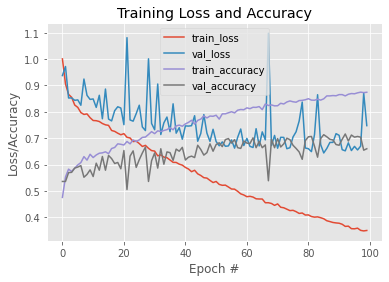

In [13]:
train_animals("drive/MyDrive/pyimagesearch/datasets/animals")

In [17]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

In [18]:
def train_cifar():
    # load the training and testing data, then scale it into the
    # range [0, 1]
    print("[INFO] loading CIFAR-10 data...")
    ((trainX, trainY), (testX, testY)) = cifar10.load_data()
    trainX = trainX.astype("float") / 255.0
    testX = testX.astype("float") / 255.0

    # convert the labels from integers to vectors
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY)
    testY = lb.transform(testY)

    # initialize the label names for the CIFAR-10 dataset
    labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01)
    model = ShallowNet.build(width=32, height=32, depth=3, classes=10)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # train the network
    print("[INFO] training network...")
    H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=40, verbose=1)

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=32)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

[INFO] loading CIFAR-10 data...
170500096/170498071 [==============================] - 4s 0us/step
[INFO] compiling model...
[INFO] training network...
Epoch 1/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.9257 - accuracy: 0.3134 - val_loss: 1.6449 - val_accuracy: 0.4308
Epoch 2/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.5909 - accuracy: 0.4474 - val_loss: 1.4827 - val_accuracy: 0.4755
Epoch 3/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.4189 - accuracy: 0.5049 - val_loss: 1.3965 - val_accuracy: 0.5079
Epoch 4/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.3348 - accuracy: 0.5301 - val_loss: 1.3659 - val_accuracy: 0.5175
Epoch 5/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.2639 - accuracy: 0.5564 - val_loss: 1.3472 - val_accuracy: 0.5251
Epoch 6/40
1563/1563 [==============================] - 34s 22ms/step - loss: 1.2047 - accuracy: 0.5774 - val_loss: 1.

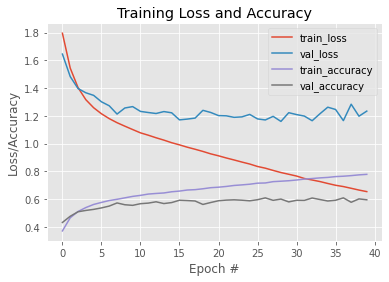

In [19]:
train_cifar()